In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import time_series_preprocessor as tsp
import matplotlib.pyplot as plt
from tensorflow.python.ops import metrics_impl

from tensorflow.python.framework import ops
import warnings
import random
import os


warnings.filterwarnings("ignore")
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
tf.logging.set_verbosity(tf.logging.ERROR)
ops.reset_default_graph()

## Using LSTM RNNs for Time Series Prediction

#### The repeating module in a standard RNN has just a single layer
<img src='../pics/RNN-unrolled.png'>

#### The repeating module in an LSTM has four interacting layers
<img src='../pics/LSTM_vs_RNN.jpg'>

#### LSTM cell state `C` is like its memory
<img src='../pics/LSTM-C-line_ch1.png'>

#### LSTM forget gate decides what, in the memory, we should forget (or downweight)
<img src='../pics/LSTM-focus-f_ch2.png'>

#### The input gate decides what new information we store in the cell state
<img src='../pics/LSTM-focus-i_ch3.png'>

#### Now we update the cell state, forgetting what we decided to forget, and adding new info scaled by how much we decided to update each state value
<img src='../pics/LSTM-focus-C_ch4.png'>

#### Finally we output a filtered version of our cell state
<img src='../pics/LSTM-focus-o_ch5.png'>

### To Summarize:
* Cell state ($\textbf{c_t}$) - Represents the **internal memory of the cell** which stores both short-term and long-term memories
* Hidden state ($\textbf{h_t}$) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the next steps in the sequence. Additionally, the hidden state can decide to only retrieve the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate ($\textbf{i_t}$) - Decides how much information from current input flows into the cell state
* Forget gate ($\textbf{f_t}$) - Decides how much information from the current input and the previous cell state flows into the current cell state
* Output gate ($\textbf{o_t}$) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

### Different diagrammatic view of the same thing
<img src='../pics/lstm_xszk4d.webp'>

### Summary of the equations:
#### input gate, forget gate, and output gate
$$i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1}+b_i)$$
$$f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1}+b_f)$$
$$o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1}+b_o)$$

#### Input transform
$$c_{in_t} = \tanh(W_{xc}x_t + W_{hc}h_{t-1} + b_{c\_in})$$

#### State update
$$c_t = f_t \cdot c_{t-1} + i_t \cdot c\_in_t$$
$$h_t=o_t \cdot tanh(c_t)$$

#### Approximation of what LSTM looks like in Tensorflow code:

In [2]:
# Hyperparameters
input_dim = 1
seq_size = 5
hidden_dim = 5

# Weight variables and input placeholders
#W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
W_out = tf.get_variable("W_out", shape=[hidden_dim, 1], dtype=tf.float32, initializer=None, regularizer=None, trainable=True, collections=None)

# b_out = tf.Variable(tf.random_normal([1]), name='b_out')
b_out = tf.get_variable("b_out", shape=[1], dtype=tf.float32, initializer=None, regularizer=None, trainable=True, collections=None)

x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
y = tf.placeholder(tf.float32, [None, seq_size])

In [3]:
def LSTM_Model():
        """
        :param x: inputs of size [T, batch_size, input_size]
        :param W: matrix of fully-connected output layer weights
        :param b: vector of fully-connected output layer biases
        """
        cell = rnn_cell.BasicLSTMCell(hidden_dim)
        outputs, states = rnn.dynamic_rnn(cell, x, dtype=tf.float32)
        num_examples = tf.shape(x)[0]
        W_repeated = tf.tile(tf.expand_dims(W_out, 0), [num_examples, 1, 1])
        out = tf.matmul(outputs, W_repeated) + b_out
        out = tf.squeeze(out)
        return out

train_loss = []
test_loss = []
step_list = []

In [4]:
def trainNetwork(train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([train_op, cost], feed_dict={x: train_x, y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(cost, feed_dict={x: test_x, y: test_y})
                    print('step: {}\t\ttrain err: {:.3f}\t\ttest err: {:.2f}'.format(step, train_err, test_err))
                    train_loss.append(train_err)
                    test_loss.append(test_err) 
                    step_list.append(step)                   

                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1                
            save_path = saver.save(sess, 'model/model.ckpt')
            print('Model saved to {}'.format(save_path))

# Cost optimizer
cost = tf.reduce_mean(tf.square(LSTM_Model()- y))
train_op = tf.train.AdamOptimizer(learning_rate=0.003).minimize(cost)

# Auxiliary ops
saver = tf.train.Saver()
def testLSTM(sess, test_x):
        tf.get_variable_scope().reuse_variables()
        saver.restore(sess, 'model/model.ckpt')
        output = sess.run(LSTM_Model(), feed_dict={x: test_x})
        return output

def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [5]:
data = tsp.load_series('../data/international-airline-passengers.csv')
train_data, actual_vals = tsp.split_data(data=data, percent_train=0.75)

In [6]:
import pandas as pd
df = pd.read_csv('../data/international-airline-passengers.csv',header=None)
df.head()

,0,1
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

step: 0		train err: 1.450		test err: 6.96
step: 100		train err: 0.243		test err: 1.42
step: 200		train err: 0.111		test err: 0.73
step: 300		train err: 0.066		test err: 0.39
step: 400		train err: 0.048		test err: 0.27
step: 500		train err: 0.040		test err: 0.21
step: 600		train err: 0.038		test err: 0.19
step: 700		train err: 0.038		test err: 0.18
step: 800		train err: 0.038		test err: 0.18
step: 900		train err: 0.038		test err: 0.18
step: 1000		train err: 0.037		test err: 0.18
step: 1100		train err: 0.037		test err: 0.18
step: 1200		train err: 0.037		test err: 0.18
Model saved to model/model.ckpt


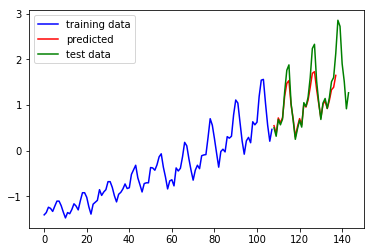

In [8]:
trainNetwork(train_x, train_y, test_x, test_y)

with tf.Session() as sess:
    predicted_vals = testLSTM(sess, test_x)[:,0]
    #print('predicted_vals', np.shape(predicted_vals))
    # Following prediction results of the model given ground truth values
    plot_results(train_data, predicted_vals, actual_vals, 'ground_truth_predition.png')

    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(100):
        next_seq = testLSTM(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))

#     # Following predictions results where only the training data was given
#     plot_results(train_data, predicted_vals, actual_vals, 'prediction_on_train_set.png')

In [9]:
def plot_error():
	# Plot loss over time
	plt.plot(step_list, train_loss, 'r--', label='LSTM training loss per iteration', linewidth=4)
	plt.title('LSTM training loss per iteration')
	plt.xlabel('Iteration')
	plt.ylabel('Training loss')
	plt.legend(loc='upper right')
	plt.show()

	# Plot accuracy over time
	plt.plot(step_list, test_loss, 'r--', label='LSTM test loss per iteration', linewidth=4)
	plt.title('LSTM test loss per iteration')
	plt.xlabel('Iteration')
	plt.ylabel('Test loss')
	plt.legend(loc='upper left')
	plt.show()

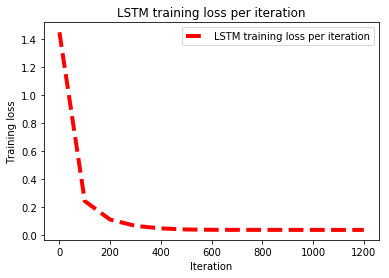

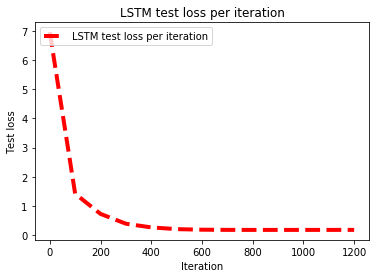

In [10]:
plot_error()